In [19]:
from svgpathtools import svg2paths, Path, Line, CubicBezier, QuadraticBezier, Arc
import numpy as np
import csv
from collections import defaultdict
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

class SVGProcessor:
    def __init__(self, svg_file: str):
        self.svg_file = svg_file
        self.all_points = []

    def extract_points_from_path(self, path_segment, num_samples=100):
        if isinstance(path_segment, (Line, CubicBezier, QuadraticBezier, Arc)):
            return [path_segment.point(t) for t in np.linspace(0, 1, num_samples)]
        return []

    def extract_all_points(self):
        paths, _ = svg2paths(self.svg_file)
        for curve_index, path in enumerate(paths):
            for segment in path:
                points = self.extract_points_from_path(segment)
                self.all_points.extend([(curve_index, 0.0000, float(p.real), float(p.imag)) for p in points])



# Example usage


In [20]:
class CurveProcessor:
    def __init__(self, curves: dict[int, List[Tuple[float, float]]], epsilon: float = 5.0, threshold: float = 5.0):
        self.curves = curves
        self.epsilon = epsilon
        self.threshold = threshold
        self.simplified_curves = {}
        self.inverse_dict = {}
        self.segment_points_dict = {}
        self.updated_curves = {}

    def point_line_distance(self, point, start, end):
        if start == end:
            return np.linalg.norm(point - start)
        else:
            n = abs((end[1] - start[1]) * point[0] - (end[0] - start[0]) * point[1] + end[0] * start[1] - end[1] * start[0])
            d = np.sqrt((end[1] - start[1]) ** 2 + (end[0] - start[0]) ** 2)
            return n / d

    def ramer_douglas_peucker(self, points, epsilon):
        dmax = 0.0
        index = 0
        end = len(points)
        for i in range(1, end - 1):
            d = self.point_line_distance(points[i], points[0], points[-1])
            if d > dmax:
                index = i
                dmax = d

        if dmax > epsilon:
            rec_results1, idx1 = self.ramer_douglas_peucker(points[:index+1], epsilon)
            rec_results2, idx2 = self.ramer_douglas_peucker(points[index:], epsilon)
            result = rec_results1[:-1] + rec_results2
            result_indices = idx1[:-1] + [i + index for i in idx2]
        else:
            result = [points[0], points[-1]]
            result_indices = [0, len(points) - 1]

        return result, result_indices

    def simplify_curves(self):
        simplified_curves = {}
        inverse_dict = {}
        segment_points_dict = {}
        segment_id = 0

        for index, points in self.curves.items():
            simplified_points, indices = self.ramer_douglas_peucker(points, self.epsilon)

            for i in range(len(simplified_points) - 1):
                start_point = tuple(simplified_points[i])
                end_point = tuple(simplified_points[i + 1])
                line_key = (start_point, end_point)

                segment_indices = indices[i:i+2]
                segment_start_idx = segment_indices[0]
                segment_end_idx = segment_indices[1]

                simplified_curves[segment_id] = [start_point, end_point]
                inverse_dict[line_key] = segment_id
                segment_points_dict[segment_id] = points[segment_start_idx:segment_end_idx+1]

                segment_id += 1

        self.simplified_curves = simplified_curves
        self.inverse_dict = inverse_dict
        self.segment_points_dict = segment_points_dict

    def distance(self, point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))

    def midpoint(self, point1, point2):
        return ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

    def round_point(self, point):
        return (round(point[0], 1), round(point[1], 1))

    def update_endpoints_with_midpoints(self):
        endpoints = {}
        updated_curves = {k: v[:] for k, v in self.simplified_curves.items()}
        inverse_dict = {}

        for key, points in self.simplified_curves.items():
            endpoints[key] = (points[0], points[-1])

        for key, (start, end) in endpoints.items():
            if self.distance(start, end) < self.threshold:
                mid = self.midpoint(start, end)
                updated_curves[key][0] = mid
                updated_curves[key][-1] = mid

        for key1, (start1, end1) in endpoints.items():
            for key2, (start2, end2) in endpoints.items():
                if key1 < key2:
                    if self.distance(start1, start2) < self.threshold:
                        mid = self.midpoint(start1, start2)
                        updated_curves[key1][0] = mid
                        updated_curves[key2][0] = mid
                    if self.distance(start1, end2) < self.threshold:
                        mid = self.midpoint(start1, end2)
                        updated_curves[key1][0] = mid
                        updated_curves[key2][-1] = mid
                    if self.distance(end1, start2) < self.threshold:
                        mid = self.midpoint(end1, start2)
                        updated_curves[key1][-1] = mid
                        updated_curves[key2][0] = mid
                    if self.distance(end1, end2) < self.threshold:
                        mid = self.midpoint(end1, end2)
                        updated_curves[key1][-1] = mid
                        updated_curves[key2][-1] = mid

        for key, points in updated_curves.items():
            updated_curves[key] = [self.round_point(point) for point in points]

        for index, points in updated_curves.items():
            for i in range(len(points) - 1):
                start_point = tuple(points[i])
                end_point = tuple(points[i + 1])
                line_key = (start_point, end_point)
                inverse_dict[line_key] = index

        self.updated_curves = updated_curves
        self.inverse_dict = inverse_dict

    def plot_segments(self, curves, inverse_dict, title):
        plt.figure(figsize=(10, 6))
        for (start, end), segment_id in inverse_dict.items():
            x = [start[0], end[0]]
            y = [start[1], end[1]]
            plt.plot(x, y, marker='o', label=f'Segment {segment_id}')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_points(self, curves, title):
        plt.figure(figsize=(10, 6))
        for points in curves.values():
            x, y = zip(*points)
            plt.plot(x, y, marker='o', linestyle='None')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()

    def process(self):
        self.simplify_curves()
        self.update_endpoints_with_midpoints()
        self.plot_segments(self.simplified_curves, self.inverse_dict, "Original Simplified Curves")
        self.plot_segments(self.updated_curves, self.inverse_dict, "Updated Curves")
        self.plot_points(self.updated_curves, "Points in Updated Curves")


In [21]:


class CycleDetector:
    def __init__(self, updated_curves: dict[int, List[Tuple[float, float]]]):
        self.adj_list, self.segments = self.construct_adj_list(updated_curves)

    def construct_adj_list(self, updated_curves):
        adj_list = defaultdict(list)
        segments = []
        for polyline in updated_curves.values():
            for i in range(len(polyline) - 1):
                start, end = polyline[i], polyline[i + 1]
                adj_list[start].append(end)
                adj_list[end].append(start)
                segments.append((start, end))
        return adj_list, segments

    def find_cycles(self, graph):
        def dfs(node, start, visited, path):
            visited[node] = True
            path.append(node)

            for neighbor in graph[node]:
                if neighbor == start and len(path) > 2:
                    cycle = path[:] + [start]
                    cycles.append(cycle)
                elif not visited[neighbor]:
                    dfs(neighbor, start, visited, path)

            path.pop()
            visited[node] = False

        cycles = []
        visited = defaultdict(bool)

        for node in graph:
            if not visited[node]:
                dfs(node, node, visited, [])

        unique_cycles = []
        for cycle in cycles:
            cycle_set = set(cycle)
            if all(cycle_set != set(c) for c in unique_cycles):
                unique_cycles.append(cycle)

        return unique_cycles

    def separate_non_cycle_lines(self, segments, cycles):
        cycle_edges = set()
        for cycle in cycles:
            for i in range(len(cycle) - 1):
                edge = tuple(sorted([cycle[i], cycle[i + 1]]))
                cycle_edges.add(edge)

        non_cycle_lines = []
        for start, end in segments:
            edge = tuple(sorted([start, end]))
            if edge not in cycle_edges:
                non_cycle_lines.append((start, end))

        return non_cycle_lines

    def process_cycles(self):
        cycles = self.find_cycles(self.adj_list)
        non_cycle_lines = self.separate_non_cycle_lines(self.segments, cycles)
        return cycles, non_cycle_lines


In [22]:
class CircleDetector:
    def __init__(self, unique_cycles):
        self.unique_cycles = unique_cycles
        self.remaining_sides = set()
        self.marked_sides = set()

    def point_to_segment_dist(self, p, v, w):
        l2 = np.sum((v - w) ** 2)
        if l2 == 0:
            return np.sum((p - v) ** 2)
        t = max(0, min(1, np.dot(p - v, w - v) / l2))
        projection = v + t * (w - v)
        return np.sum((p - projection) ** 2)

    def mean_square_circle_error(self, polygon, center, radius, num_points=100):
        total_error = 0
        total_samples = 0

        for i in range(len(polygon)):
            p1 = polygon[i]
            p2 = polygon[(i + 1) % len(polygon)]

            segment_points = np.linspace(p1, p2, num_points)

            for point in segment_points:
                closest_point = self.closest_point_on_circle(point, center, radius)
                dist = np.linalg.norm(point - closest_point)
                error = dist ** 2
                total_error += error

            total_samples += len(segment_points)

        mse = total_error / total_samples
        return mse

    def closest_point_on_circle(self, point, center, radius):
        direction = point - center
        direction /= np.linalg.norm(direction)
        return center + direction * radius

    def best_fit_circle(self, polygon):
        polygon = np.array(polygon)

        best_mse = float('inf')
        best_center = None
        best_radius = None

        for _ in range(50): 
            sample_indices = np.random.choice(len(polygon), 3, replace=False)
            sample_points = polygon[sample_indices]

            A = sample_points[0]
            B = sample_points[1]
            C = sample_points[2]

            D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))
            if D == 0:
                continue

            Ux = ((A[0]**2 + A[1]**2) * (B[1] - C[1]) + (B[0]**2 + B[1]**2) * (C[1] - A[1]) + (C[0]**2 + C[1]**2) * (A[1] - B[1])) / D
            Uy = ((A[0]**2 + A[1]**2) * (C[0] - B[0]) + (B[0]**2 + B[1]**2) * (A[0] - C[0]) + (C[0]**2 + C[1]**2) * (B[0] - A[0])) / D
            center = np.array([Ux, Uy])
            radius = np.linalg.norm(center - A)

            mse = self.mean_square_circle_error(polygon, center, radius)
            if mse < best_mse:
                best_mse = mse
                best_center = center
                best_radius = radius

        return best_center, best_radius, best_mse

    def plot_polygon_and_circle(self, polygon, center, radius, label):
        polygon = np.array(polygon)  # Ensure polygon is a numpy array
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = center[0] + radius * np.cos(theta)
        circle_y = center[1] + radius * np.sin(theta)

        plt.plot(circle_x, circle_y, 'r--', label=label)
        plt.scatter(*center, color='green', zorder=5, label='Center')

    def plot_remaining_sides(self, unique_cycles, marked_sides):
        for polygon in unique_cycles:
            polygon = np.array(polygon)
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side not in marked_sides:
                    plt.plot(*np.array([polygon[i], polygon[(i + 1) % len(polygon)]]).T, 'k-', label='Remaining Side' if i == 0 else "")

    def detect_circles(self):
        min_heap = []
        possible_circles = []
        unused_loops = []

        for polygon in self.unique_cycles:
            center, radius, mse = self.best_fit_circle(polygon)
            heapq.heappush(min_heap, (mse, center, radius, polygon))

        while min_heap:
            mse, center, radius, polygon = heapq.heappop(min_heap)

            contains_marked_side = False
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side in self.marked_sides:
                    contains_marked_side = True
                    break

            if contains_marked_side:
                unused_loops.append(polygon)
                continue

            self.plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')
            self.plot_remaining_sides(self.unique_cycles, self.marked_sides)
            plt.legend()
            plt.axis('equal')
            plt.show()
            print(mse)
            if mse < 75:
                print(f'Mean Square Fitting Error: {mse:.4f}')
                possible_circles.append((center, radius, polygon))

                for i in range(len(polygon)):
                    side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                    self.marked_sides.add(side)
            else:
                unused_loops.append(polygon)

        filtered_unused_loops = []
        for loop in unused_loops:
            all_sides_unused = True
            for i in range(len(loop)):
                side = tuple(sorted([tuple(loop[i]), tuple(loop[(i + 1) % len(loop)])]))
                if side in self.marked_sides:
                    all_sides_unused = False
                    break
            if all_sides_unused:
                filtered_unused_loops.append(loop)

        plt.figure()

        self.plot_remaining_sides(self.unique_cycles, self.marked_sides)
        for polygon in self.unique_cycles:
            polygon = np.array(polygon)
            for i in range(len(polygon)):
                side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
                if side not in self.marked_sides:
                    self.remaining_sides.add(side)

        self.remaining_sides = set([
            ((float(x1), float(y1)), (float(x2), float(y2)))
            for ((x1, y1), (x2, y2)) in self.remaining_sides
        ])

        for center, radius, polygon in possible_circles:
            self.plot_polygon_and_circle(polygon, center, radius, label='Best Fit Circle')

        plt.legend()
        plt.axis('equal')
        plt.show()

        return filtered_unused_loops, possible_circles


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def are_approximately_equal(p1, p2, tol=5):
    return np.linalg.norm(np.array(p1) - np.array(p2)) < tol

def compute_slope(p1, p2):
    if p2[0] == p1[0]:
        return np.inf
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

class SegmentProcessor:
    def __init__(self, segments, tol=1):
        self.segments = segments
        self.tol = tol
        self.merged_segments = []
        self.map = {}
        self.common_vertex_segments = []
        self.filtered_merged_segments = []

    def merge_collinear_segments(self):
        merged_segments = []
        used = set()
        segment_map = {}
        
        while len(used) < len(self.segments):
            for i, (start1, end1) in enumerate(self.segments):
                if i not in used:
                    break

            collinear_group = [(start1, end1)]
            used.add(i)

            while True:
                merged = False
                for j, (start2, end2) in enumerate(self.segments):
                    if j in used:
                        continue
                    
                    if (np.abs(compute_slope(start1, end1) - compute_slope(start2, end2)) < self.tol):
                        if any(are_approximately_equal(start, start2) or 
                               are_approximately_equal(start, end2) or
                               are_approximately_equal(end, start2) or 
                               are_approximately_equal(end, end2) for start, end in collinear_group):
                            collinear_group.append((start2, end2))
                            used.add(j)
                            merged = True

                if not merged:
                    break

            all_points = np.array([point for segment in collinear_group for point in segment])
            min_idx = np.argmin(all_points[:, 0])
            max_idx = np.argmax(all_points[:, 0])
            min_y_idx = np.argmin(all_points[:, 1])
            max_y_idx = np.argmax(all_points[:, 1])

            if np.abs(compute_slope(start1, end1)) < self.tol:
                merged_segments.append((tuple(all_points[min_idx]), tuple(all_points[max_idx])))
                segment_map[(tuple(all_points[min_idx]), tuple(all_points[max_idx]))] = collinear_group
            else:
                segment_map[(tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx]))] = collinear_group
                merged_segments.append((tuple(all_points[min_y_idx]), tuple(all_points[max_y_idx])))

        self.merged_segments = merged_segments
        self.map = segment_map

    def find_segments_with_common_vertices(self):
        common_vertex_segments = []
        for i, (start1, end1) in enumerate(self.merged_segments):
            for j, (start2, end2) in enumerate(self.merged_segments):
                if i != j:
                    if are_approximately_equal(start1, start2, self.tol) or are_approximately_equal(start1, end2, self.tol) or \
                       are_approximately_equal(end1, start2, self.tol) or are_approximately_equal(end1, end2, self.tol):
                        common_vertex_segments.append((start1, end1))
                        break
        self.common_vertex_segments = common_vertex_segments

    def revert_to_original_segments(self):
        reverted_segments = []
        for segment in self.common_vertex_segments:
            reverted_segments += self.map[segment]
        return reverted_segments

    def filter_merged_segments(self):
        self.filtered_merged_segments = [seg for seg in self.merged_segments if seg not in self.common_vertex_segments]

    def plot_segments(self, segments, title, highlight_segments=None):
        plt.figure(figsize=(10, 8))
        for (start, end) in segments:
            plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='blue')
        if highlight_segments:
            for (start, end) in highlight_segments:
                plt.plot([start[0], end[0]], [start[1], end[1]], marker='o', color='red')
        plt.title(title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)
        plt.show()


# Example usage



In [24]:
import math
import heapq
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

class PolygonDetection:
    def __init__(self, error_threshold=150):
        self.error_threshold = error_threshold
        
    def sample_points_along_segment(self, p1, p2, num_points=100):
        return np.linspace(p1, p2, num_points)

    def calculate_angle_between_lines(self, line1, line2):
        def vector_from_line(line):
            (x1, y1), (x2, y2) = line
            return (x2 - x1, y2 - y1)

        common_points = set(line1) & set(line2)
        if len(common_points) == 0:
            return None

        vec1 = vector_from_line(line1)
        vec2 = vector_from_line(line2)

        magnitude1 = math.sqrt(vec1[0]**2 + vec1[1]**2)
        magnitude2 = math.sqrt(vec2[0]**2 + vec2[1]**2)

        if magnitude1 == 0 or magnitude2 == 0:
            return None

        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        cos_theta = dot_product / (magnitude1 * magnitude2)

        cos_theta = min(1, max(-1, cos_theta))

        angle = math.degrees(math.acos(cos_theta))
        return angle

    def are_points_close(self, p1, p2, tolerance=5):
        return np.linalg.norm(np.array(p1) - np.array(p2)) < tolerance

    def process_polygons(self, polygons):
        vertices_arr = []
        lines_arr = []

        for points in polygons:
            lines = []
            for i in range(len(points) - 1):
                lines.append((points[i], points[(i + 1) % len(points)]))

            heap = []
            for i in range(len(lines)):
                angle = self.calculate_angle_between_lines(lines[i], lines[(i + 1) % len(lines)])
                if angle is not None:
                    heapq.heappush(heap, (abs(90 - angle), lines[i], lines[(i + 1) % len(lines)]))

            vertices = set()
            while heap:
                angle_diff, line1, line2 = heapq.heappop(heap)
                if angle_diff < 360 / (len(vertices) + 1):
                    common_point = tuple(set(line1) & set(line2))
                    if common_point:
                        if not any(self.are_points_close(common_point, v) for v in vertices):
                            vertices.add(common_point)

            vertices = np.array(list(vertices))
            if vertices.ndim > 2:
                vertices = vertices.reshape(-1, 2)

            print(vertices)
            vertices = self.filter_points(vertices)
            vertices_arr.append(vertices)
            lines_arr.append(lines)

        return vertices_arr, lines_arr

    def calculate_distance(self, p1, p2):
        """Calculate the Euclidean distance between two points."""
        print(p1, p2, np.linalg.norm(p2 - p1))
        return np.linalg.norm(p2 - p1)

    def filter_points(self, points):
        distances = [self.calculate_distance(points[i], points[(i+1) % len(points)]) for i in range(len(points))]
        max_distance = max(distances)
        print(max_distance)
        threshold = 0.55 * max_distance
        i = 0
        while i < len(points):
            if distances[i] < threshold:
                dist_prev = self.calculate_distance(points[(i-1 + len(points)) % len(points)], points[i])
                dist_next = self.calculate_distance(points[(i+1) % len(points)], points[(i+2) % len(points)])
                
                if dist_prev >= dist_next:
                    points = np.delete(points, i, axis=0)
                else:
                    points = np.delete(points, (i+1) % len(points), axis=0)
                
                distances = [self.calculate_distance(points[j], points[(j+1) % len(points)]) for j in range(len(points))]
            else:
                i += 1
        
        return points


    def calculate_angle(self, point, centroid):
        return np.arctan2(point[1] - centroid[1], point[0] - centroid[0])

    def get_best_fit_polygon(self, vertices, lines):
        centroid = np.mean(vertices, axis=0)
        distances = np.linalg.norm(vertices - centroid, axis=1)
        average_radius = np.mean(distances)
        n_vertices = len(vertices)

        def generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=0):
            angles = np.linspace(0, 2 * np.pi, n_vertices, endpoint=False) + rotation_angle
            return np.array([
                [centroid[0] + radius * np.cos(angle), centroid[1] + radius * np.sin(angle)]
                for angle in angles
            ])

        def fit_score(vertices, approx_vertices):
            return np.sum(cdist(vertices, approx_vertices, 'euclidean').min(axis=1))

        

        def line_fit_score(lines, approx_vertices):
            total_distance = 0
            total_samples = 0

            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, approx_vertices, 'euclidean').min(axis=1)
                total_distance += np.sum(distances)
                total_samples += len(distances)

            return total_distance / total_samples

        best_fit_polygon = None
        best_fit_score = float('inf')
        best_rotation_angle = 0
        best_radius = average_radius

        radii = np.linspace(average_radius - 1, average_radius + 1, 50)
        for radius in radii:
            for angle in np.linspace(0, 2 * np.pi, 360):
                approx_vertices = generate_regular_polygon(centroid, radius, n_vertices, rotation_angle=angle)
                vertex_score = fit_score(vertices, approx_vertices)
                line_score = line_fit_score(lines, approx_vertices)
                score = vertex_score + line_score
                if score < best_fit_score:
                    best_fit_score = score
                    best_fit_polygon = approx_vertices
                    best_rotation_angle = angle
                    best_radius = radius
                # print(score)

        return best_fit_polygon, best_rotation_angle, best_radius

    def process_polygons_with_fit(self, vertices_list, lines_list):
        valid_polygons = []
        rejected_polygons = []
        remaining_segments = []

        for vertices, lines in zip(vertices_list, lines_list):
            if len(vertices) == 0 or len(lines) == 0:
                continue

            best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)

            line_errors = []
            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
                line_errors.append(np.mean(distances))

            if any(error > self.error_threshold for error in line_errors):
                rejected_polygons.append((vertices, lines))
                for line in lines:
                    remaining_segments.append(line)
                continue

            valid_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))

        return valid_polygons, rejected_polygons, remaining_segments

    def handle_remaining_segments(self, remaining_segments):
        heapq.heapify(remaining_segments)
        final_polygons = []
        utilized_segments = set()

        while remaining_segments:
            current_segment = heapq.heappop(remaining_segments)
            if any(tuple(map(tuple, segment)) in utilized_segments for segment in current_segment):
                continue

            remaining_polygons = [segment for segment in current_segment if tuple(map(tuple, segment)) not in utilized_segments]

            if len(remaining_polygons) == 0:
                continue

            vertices = np.array([point for segment in remaining_polygons for point in segment])
            lines = remaining_polygons
            best_fit_polygon, best_rotation_angle, best_radius = self.get_best_fit_polygon(vertices, lines)

            line_errors = []
            for line in lines:
                p1, p2 = line
                segment_points = self.sample_points_along_segment(p1, p2)
                distances = cdist(segment_points, best_fit_polygon, 'euclidean').min(axis=1)
                line_errors.append(np.mean(distances))

            # print(line_errors)
            if any(error > self.error_threshold for error in line_errors):
                for line in lines:
                    remaining_segments.append(line)
                continue

            final_polygons.append((best_fit_polygon, best_rotation_angle, best_radius))
            for segment in lines:
                utilized_segments.add(tuple(map(tuple, segment)))

        return final_polygons

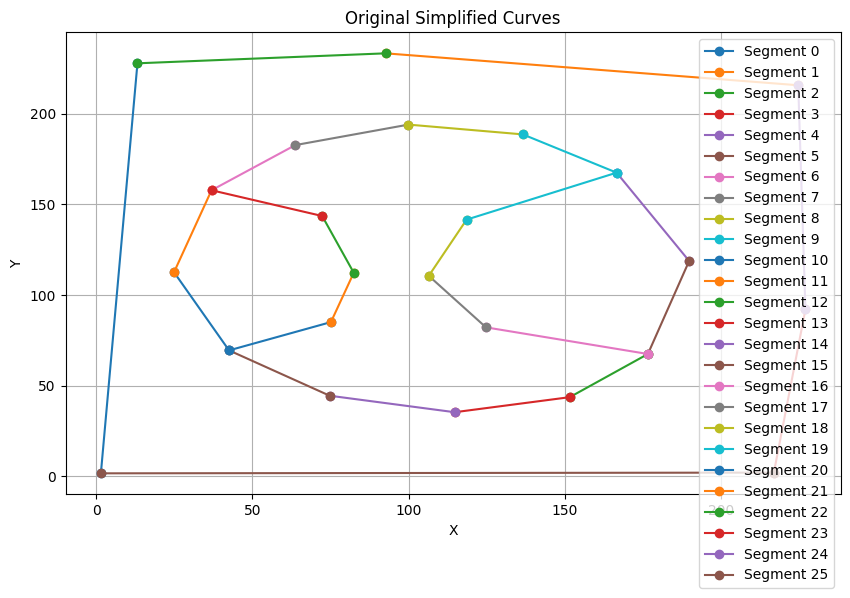

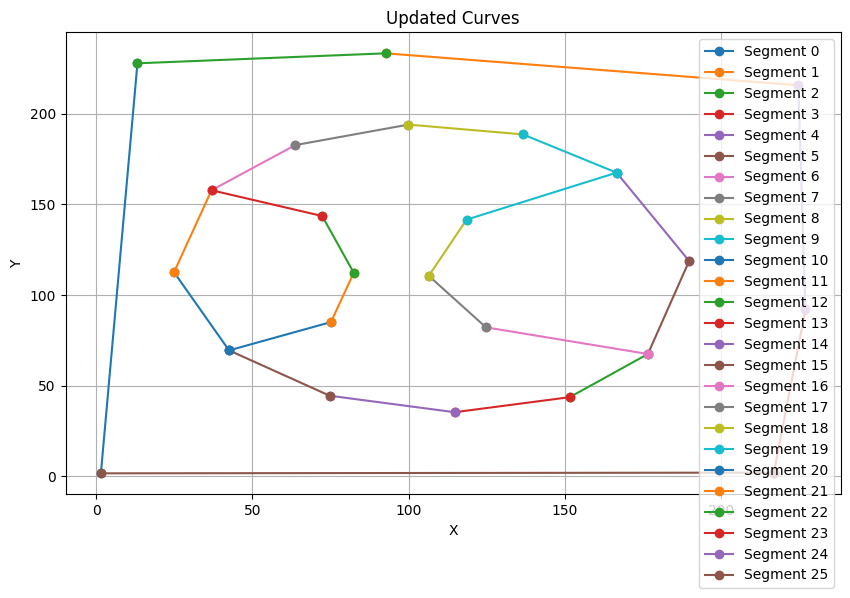

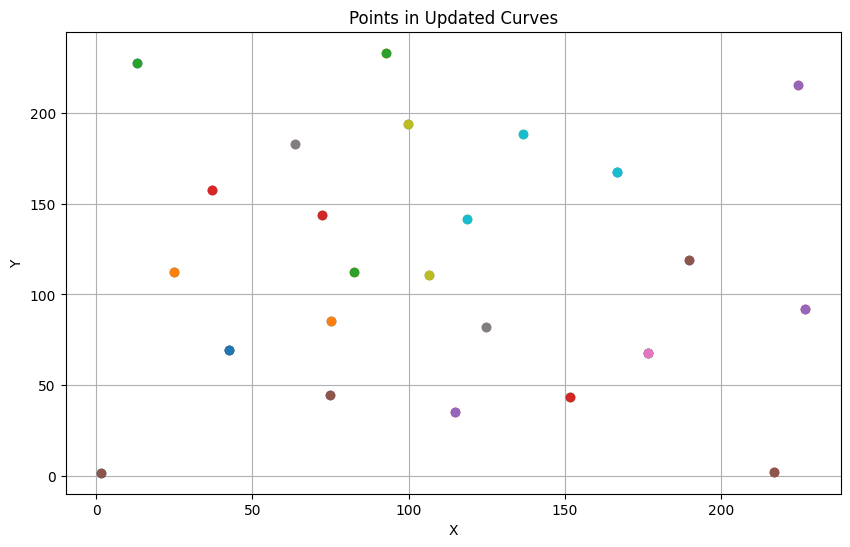

Unique Cycles:
[(42.5, 69.5), (24.9, 112.6), (36.9, 157.8), (63.7, 182.7), (99.9, 194.0), (136.5, 188.6), (166.5, 167.5), (189.7, 118.8), (176.5, 67.5), (151.5, 43.7), (114.7, 35.4), (74.7, 44.5), (42.5, 69.5)]
[(42.5, 69.5), (24.9, 112.6), (36.9, 157.8), (63.7, 182.7), (99.9, 194.0), (136.5, 188.6), (166.5, 167.5), (118.5, 141.6), (106.4, 110.6), (124.7, 82.2), (176.5, 67.5), (151.5, 43.7), (114.7, 35.4), (74.7, 44.5), (42.5, 69.5)]
[(42.5, 69.5), (24.9, 112.6), (36.9, 157.8), (72.3, 143.6), (82.4, 112.3), (75.1, 85.1), (42.5, 69.5)]
[(42.5, 69.5), (74.7, 44.5), (114.7, 35.4), (151.5, 43.7), (176.5, 67.5), (189.7, 118.8), (166.5, 167.5), (136.5, 188.6), (99.9, 194.0), (63.7, 182.7), (36.9, 157.8), (72.3, 143.6), (82.4, 112.3), (75.1, 85.1), (42.5, 69.5)]
[(42.5, 69.5), (74.7, 44.5), (114.7, 35.4), (151.5, 43.7), (176.5, 67.5), (124.7, 82.2), (106.4, 110.6), (118.5, 141.6), (166.5, 167.5), (136.5, 188.6), (99.9, 194.0), (63.7, 182.7), (36.9, 157.8), (72.3, 143.6), (82.4, 112.3), (75.1,

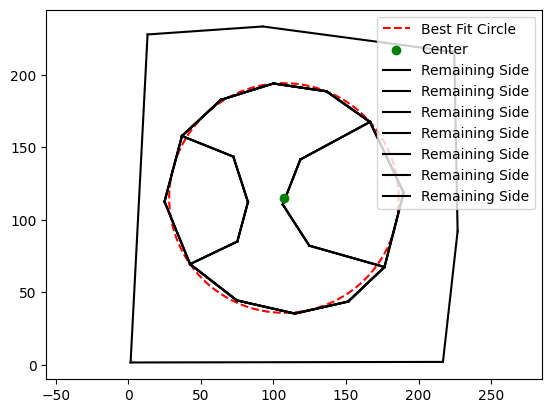

3.8897215476233438
Mean Square Fitting Error: 3.8897


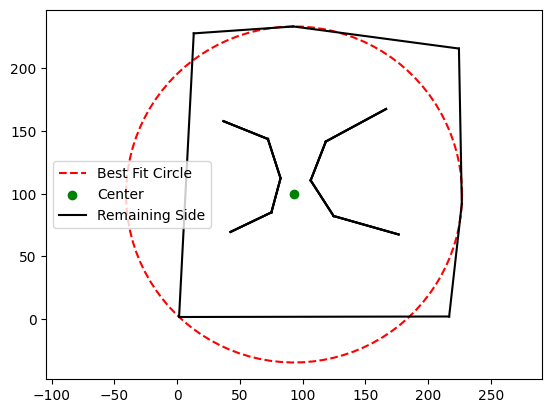

391.3418096003193


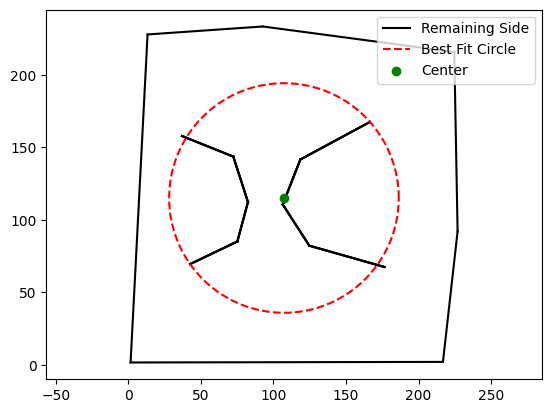

[(array([107.2072403 , 115.07451227]), np.float64(79.14583448419224), [(42.5, 69.5), (24.9, 112.6), (36.9, 157.8), (63.7, 182.7), (99.9, 194.0), (136.5, 188.6), (166.5, 167.5), (189.7, 118.8), (176.5, 67.5), (151.5, 43.7), (114.7, 35.4), (74.7, 44.5), (42.5, 69.5)])]
Unused Loops:
[(13.2, 227.8), (1.5, 1.7), (216.8, 2.1), (226.9, 92.1), (224.6, 215.7), (92.6, 233.3), (13.2, 227.8)]
{((np.float64(124.7), np.float64(82.2)), (np.float64(176.5), np.float64(67.5))), ((np.float64(42.5), np.float64(69.5)), (np.float64(75.1), np.float64(85.1))), ((np.float64(176.5), np.float64(67.5)), (np.float64(176.5), np.float64(67.5))), ((np.float64(36.9), np.float64(157.8)), (np.float64(72.3), np.float64(143.6))), ((np.float64(72.3), np.float64(143.6)), (np.float64(82.4), np.float64(112.3))), ((np.float64(75.1), np.float64(85.1)), (np.float64(82.4), np.float64(112.3))), ((np.float64(118.5), np.float64(141.6)), (np.float64(166.5), np.float64(167.5))), ((np.float64(106.4), np.float64(110.6)), (np.float64(12

In [25]:
svg_processor = SVGProcessor(svg_file='./data/problems/frag0.svg')
svg_processor.extract_all_points()

curves = defaultdict(list)
for point in svg_processor.all_points:
    curve_index, _, x, y = point
    curves[curve_index].append((x, y))

curve_processor = CurveProcessor(curves)
curve_processor.process()
curves = curve_processor.segment_points_dict

cycle_detector = CycleDetector(curve_processor.updated_curves)
cycles, non_cycle_lines = cycle_detector.process_cycles()
print("Unique Cycles:")
for cycle in cycles:
    print(cycle)

print("\nNon-Cycle Lines:")
for line in non_cycle_lines:
    print(line)

circle_detector = CircleDetector(cycles)
remaining_sides = circle_detector.remaining_sides
filtered_unused_loops, possible_circles = circle_detector.detect_circles()
print(possible_circles)

unique_cycles = circle_detector.unique_cycles

print("Unused Loops:")
for loop in filtered_unused_loops:
    print(loop)
    
    for polygon in unique_cycles:
        for i in range(len(polygon)):
            side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
            remaining_sides.add(side)

# Remove sides in possible_circles
for _, _, polygon in possible_circles:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in remaining_sides:
            remaining_sides.remove(side)

# Remove sides in filtered_unused_loops
for polygon in filtered_unused_loops:
    for i in range(len(polygon)):
        side = tuple(sorted([tuple(polygon[i]), tuple(polygon[(i + 1) % len(polygon)])]))
        if side in remaining_sides:
            remaining_sides.remove(side)

print(remaining_sides)


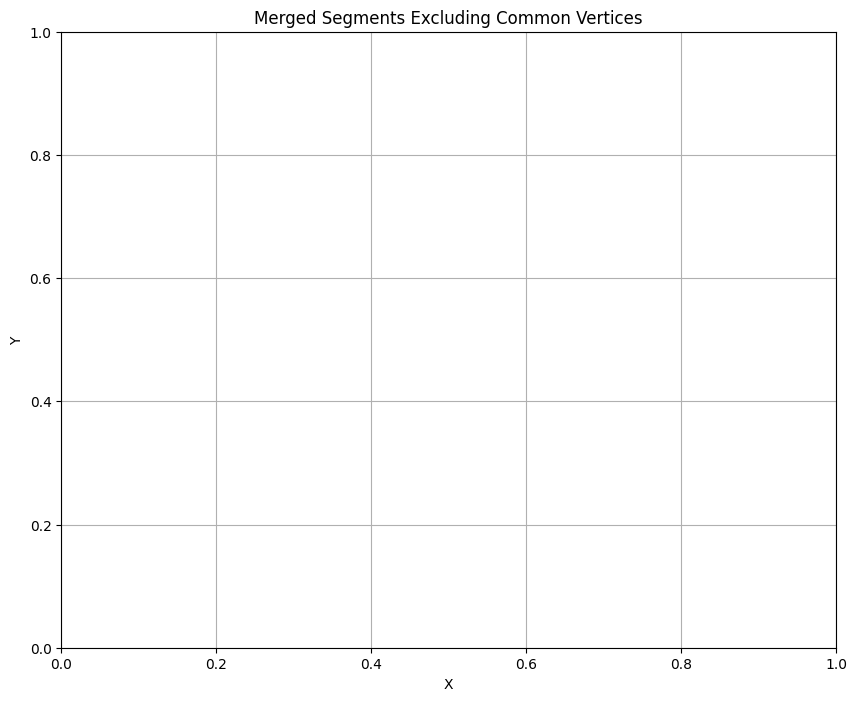

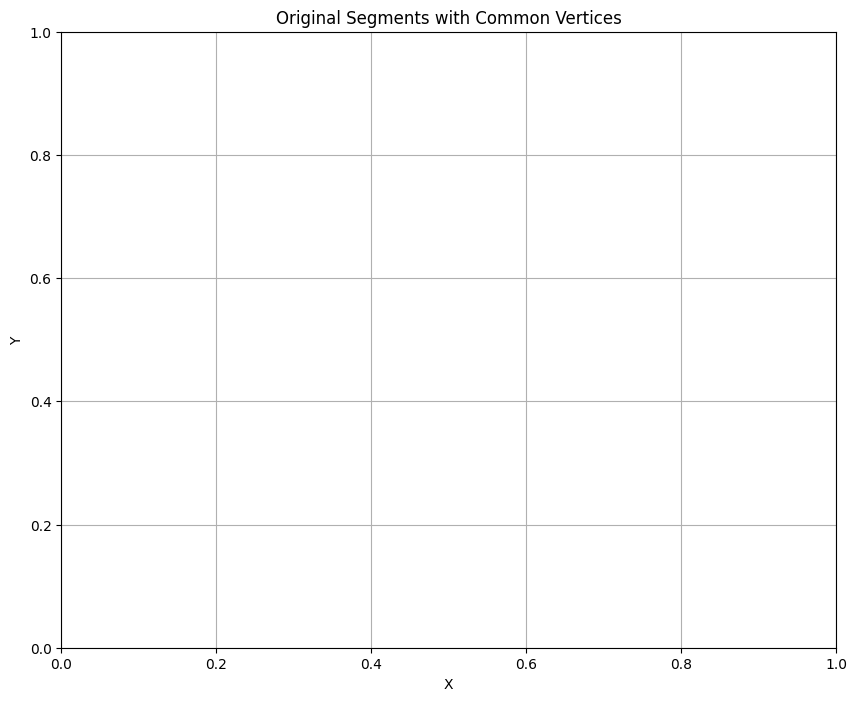

{((np.float64(75.1), np.float64(85.1)), (np.float64(82.4), np.float64(112.3))), ((np.float64(124.7), np.float64(82.2)), (np.float64(176.5), np.float64(67.5))), ((np.float64(118.5), np.float64(141.6)), (np.float64(166.5), np.float64(167.5))), ((np.float64(42.5), np.float64(69.5)), (np.float64(75.1), np.float64(85.1))), ((np.float64(106.4), np.float64(110.6)), (np.float64(124.7), np.float64(82.2))), ((np.float64(176.5), np.float64(67.5)), (np.float64(176.5), np.float64(67.5))), ((np.float64(36.9), np.float64(157.8)), (np.float64(72.3), np.float64(143.6))), ((np.float64(72.3), np.float64(143.6)), (np.float64(82.4), np.float64(112.3))), ((np.float64(106.4), np.float64(110.6)), (np.float64(118.5), np.float64(141.6)))}


In [26]:
segments = list(non_cycle_lines)

segment_processor = SegmentProcessor(segments)
segment_processor.merge_collinear_segments()
segment_processor.find_segments_with_common_vertices()
rem = segment_processor.revert_to_original_segments()
segment_processor.filter_merged_segments()

segment_processor.plot_segments(segment_processor.filtered_merged_segments, "Merged Segments Excluding Common Vertices")
segment_processor.plot_segments(rem, "Original Segments with Common Vertices")

remaining_sides = remaining_sides.union(set(rem))
print(remaining_sides)

[[224.6 215.7]
 [216.8   2.1]
 [ 13.2 227.8]
 [  1.5   1.7]]
[224.6 215.7] [216.8   2.1] 213.7423682848115
[216.8   2.1] [ 13.2 227.8] 303.962908921467
[ 13.2 227.8] [1.5 1.7] 226.4025176538459
[1.5 1.7] [224.6 215.7] 309.14334862649076
309.14334862649076
Vertices Array:
[array([[224.6, 215.7],
       [216.8,   2.1],
       [ 13.2, 227.8],
       [  1.5,   1.7]])]
Lines Array:
[[((13.2, 227.8), (1.5, 1.7)), ((1.5, 1.7), (216.8, 2.1)), ((216.8, 2.1), (226.9, 92.1)), ((226.9, 92.1), (224.6, 215.7)), ((224.6, 215.7), (92.6, 233.3)), ((92.6, 233.3), (13.2, 227.8))]]


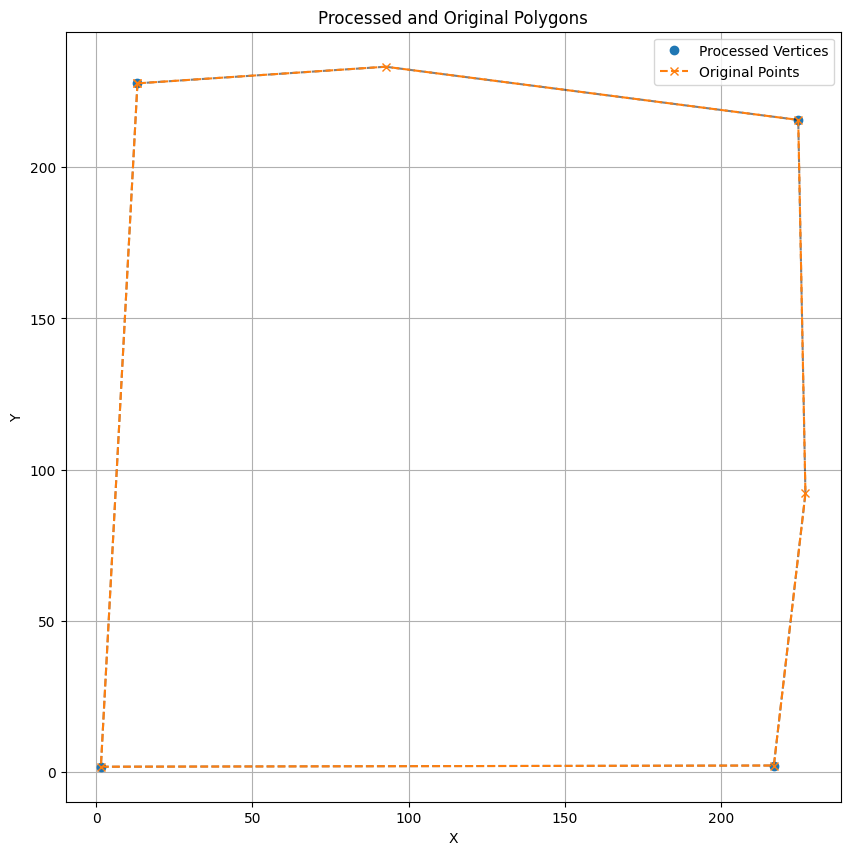

vertices_arr [array([[224.6, 215.7],
       [216.8,   2.1],
       [ 13.2, 227.8],
       [  1.5,   1.7]])]
lines_arr [[((13.2, 227.8), (1.5, 1.7)), ((1.5, 1.7), (216.8, 2.1)), ((216.8, 2.1), (226.9, 92.1)), ((226.9, 92.1), (224.6, 215.7)), ((224.6, 215.7), (92.6, 233.3)), ((92.6, 233.3), (13.2, 227.8))]]
Valid Polygons:
[(array([[225.18816038, 215.92164086],
       [  9.92835914, 222.98816038],
       [  2.86183962,   7.72835914],
       [218.12164086,   0.66183962]]), np.float64(0.7525820841468585), np.float64(152.29365995926838))]
Rejected Polygons:
[]
Final Polygons from Remaining Segments:
[]


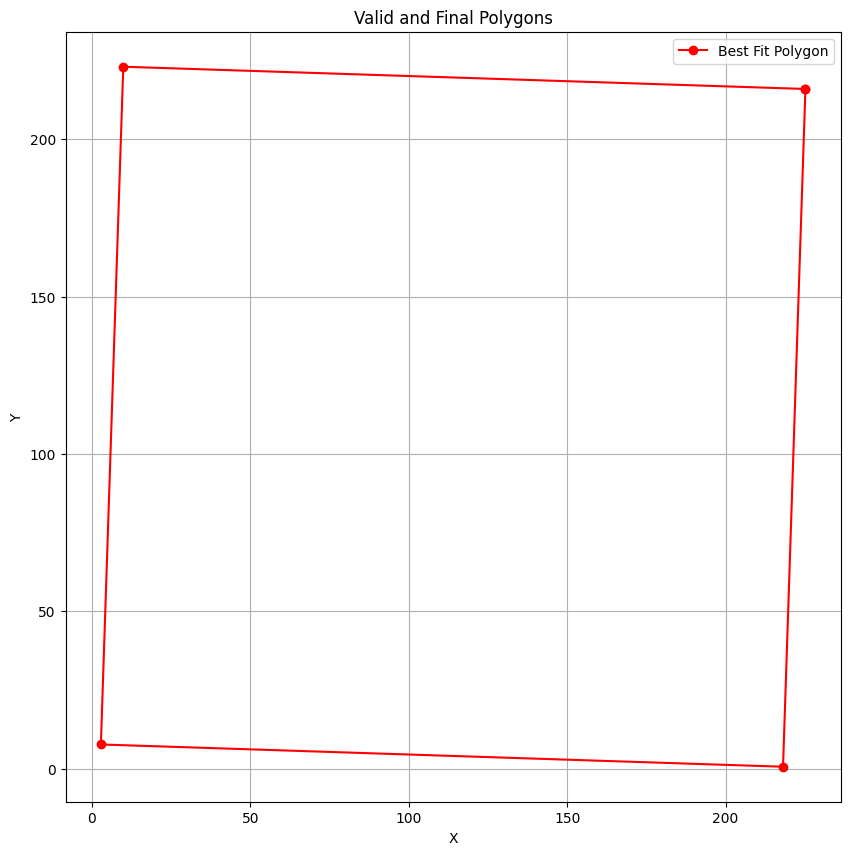

In [27]:
polygon_detection = PolygonDetection()


# Process the polygons to get vertices and lines
vertices_arr, lines_arr = polygon_detection.process_polygons(filtered_unused_loops)
print("Vertices Array:")
print(vertices_arr)
print("Lines Array:")
print(lines_arr)

# Plot the polygons
plt.figure(figsize=(10, 10))
for vertices in vertices_arr:
    if len(vertices) > 0:  # Check if vertices is not empty
        plt.plot(vertices[:, 0], vertices[:, 1], 'o', label='Processed Vertices')

for lines in lines_arr:
    for line in lines:
        x_values, y_values = zip(*line)
        plt.plot(x_values, y_values, 'k--', alpha=0.5)

# Plot the original points for reference
for points in filtered_unused_loops:
    plt.plot([p[0] for p in points], [p[1] for p in points], 'x--', label='Original Points')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Processed and Original Polygons')
plt.legend()
plt.grid(True)
plt.show()

# Process polygons to find valid and rejected polygons
print("vertices_arr", vertices_arr)
print("lines_arr", lines_arr)
valid_polygons, rejected_polygons, remaining_segments = polygon_detection.process_polygons_with_fit(vertices_arr, lines_arr)

# Handle remaining segments to form final polygons
final_polygons = polygon_detection.handle_remaining_segments(remaining_segments)

print("Valid Polygons:")
print(valid_polygons)

print("Rejected Polygons:")
print(rejected_polygons)

print("Final Polygons from Remaining Segments:")
print(final_polygons)

# Plot valid and final polygons
plt.figure(figsize=(10, 10))
for best_fit_polygon, best_rotation_angle, best_radius in valid_polygons:
    plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
             np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

for best_fit_polygon, best_rotation_angle, best_radius in final_polygons:
    plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
             np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'go-', label='Final Polygon')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Valid and Final Polygons')
plt.grid(True)
plt.show()


((75.1, 85.1), (82.4, 112.3))
11
11
((124.7, 82.2), (176.5, 67.5))
16
16
((118.5, 141.6), (166.5, 167.5))
19
19
((42.5, 69.5), (75.1, 85.1))
10
10
((106.4, 110.6), (124.7, 82.2))
17
17
((176.5, 67.5), (176.5, 67.5))
Side ((176.5, 67.5), (176.5, 67.5)) not found in inverse_dict.
((36.9, 157.8), (72.3, 143.6))
13
13
((72.3, 143.6), (82.4, 112.3))
12
12
((106.4, 110.6), (118.5, 141.6))
18
18
{((42.5, 69.5), (24.9, 112.6)): 0, ((24.9, 112.6), (36.9, 157.8)): 1, ((176.5, 67.5), (151.5, 43.7)): 2, ((151.5, 43.7), (114.7, 35.4)): 3, ((114.7, 35.4), (74.7, 44.5)): 4, ((74.7, 44.5), (42.5, 69.5)): 5, ((36.9, 157.8), (63.7, 182.7)): 6, ((63.7, 182.7), (99.9, 194.0)): 7, ((99.9, 194.0), (136.5, 188.6)): 8, ((136.5, 188.6), (166.5, 167.5)): 9, ((42.5, 69.5), (75.1, 85.1)): 10, ((75.1, 85.1), (82.4, 112.3)): 11, ((82.4, 112.3), (72.3, 143.6)): 12, ((72.3, 143.6), (36.9, 157.8)): 13, ((166.5, 167.5), (189.7, 118.8)): 14, ((189.7, 118.8), (176.5, 67.5)): 15, ((176.5, 67.5), (124.7, 82.2)): 16, ((124.

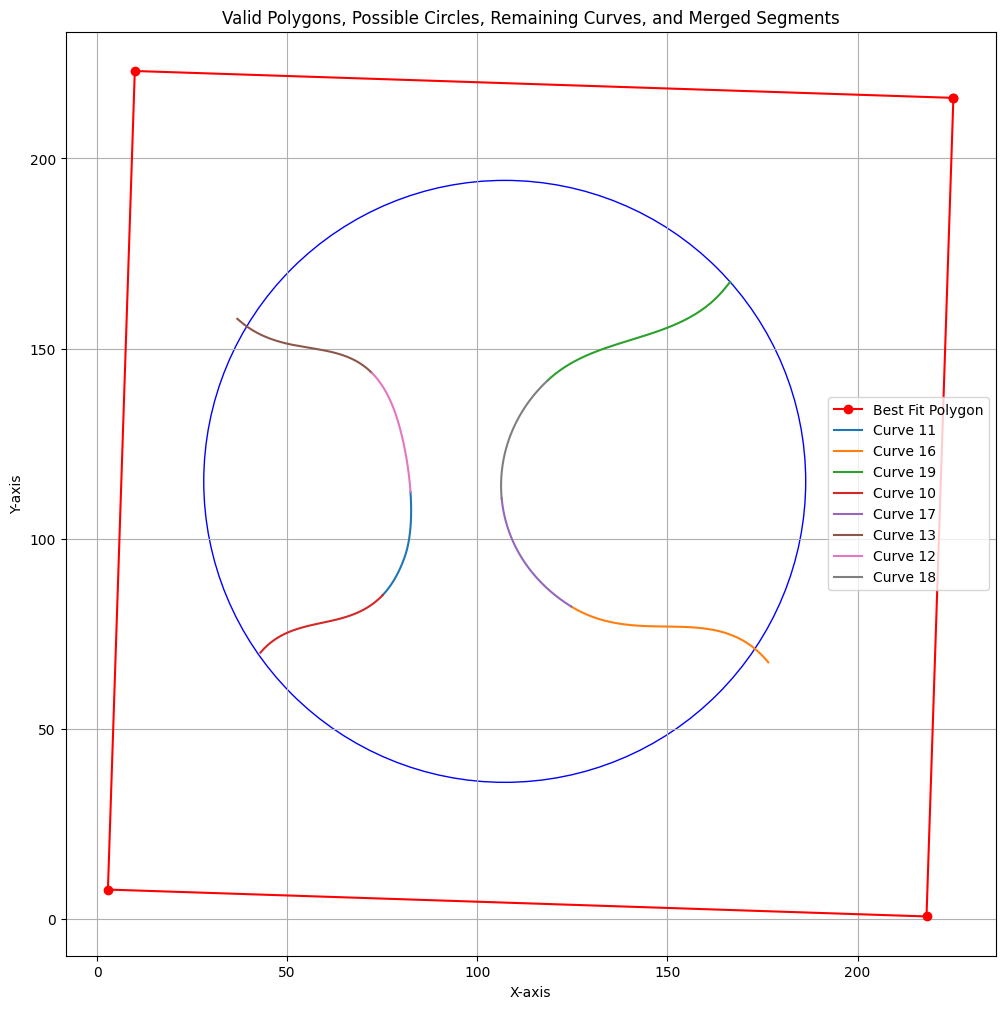

{((np.float64(75.1), np.float64(85.1)), (np.float64(82.4), np.float64(112.3))), ((np.float64(124.7), np.float64(82.2)), (np.float64(176.5), np.float64(67.5))), ((np.float64(118.5), np.float64(141.6)), (np.float64(166.5), np.float64(167.5))), ((np.float64(42.5), np.float64(69.5)), (np.float64(75.1), np.float64(85.1))), ((np.float64(106.4), np.float64(110.6)), (np.float64(124.7), np.float64(82.2))), ((np.float64(176.5), np.float64(67.5)), (np.float64(176.5), np.float64(67.5))), ((np.float64(36.9), np.float64(157.8)), (np.float64(72.3), np.float64(143.6))), ((np.float64(72.3), np.float64(143.6)), (np.float64(82.4), np.float64(112.3))), ((np.float64(106.4), np.float64(110.6)), (np.float64(118.5), np.float64(141.6)))}


In [28]:

import numpy as np
import matplotlib.pyplot as plt

def plot_all(valid_polygons, possible_circles, remaining_sides, curves, inverse_dict, merged_segments):
    plt.figure(figsize=(12, 12))
    remaining_sides = set([
        ((float(x1), float(y1)), (float(x2), float(y2)))
        for ((x1, y1), (x2, y2)) in remaining_sides
    ])

    all_x = []
    all_y = []

    for best_fit_polygon, best_rotation_angle, best_radius in valid_polygons:
        all_x.extend(best_fit_polygon[:, 0])
        all_y.extend(best_fit_polygon[:, 1])
        plt.plot(np.append(best_fit_polygon[:, 0], best_fit_polygon[0, 0]), 
                 np.append(best_fit_polygon[:, 1], best_fit_polygon[0, 1]), 'ro-', label='Best Fit Polygon')

    # print(possible_circles)
    for center, radius, circle_points in possible_circles:
        circle = plt.Circle(center, radius, color='b', fill=False)
        plt.gca().add_artist(circle)
        all_x.append(center[0] + radius)
        all_x.append(center[0] - radius)
        all_y.append(center[1] + radius)
        all_y.append(center[1] - radius)
        circle_points = np.array(circle_points)
        all_x.extend(circle_points[:, 0])
        all_y.extend(circle_points[:, 1])

    plotted_curves = set()
    
    for side in remaining_sides:
        print(side)
        if side in inverse_dict:
            curve_num = inverse_dict[side]
            # print(inverse_dict[side])
        elif (side[1], side[0]) in inverse_dict:
            curve_num = inverse_dict[(side[1], side[0])]
        else:
            print(f"Side {side} not found in inverse_dict.")
            continue
        
        print(curve_num)
        if curve_num not in plotted_curves:
            if curve_num in curves:
                print(curve_num)
                points = curves[curve_num]
                # Unpack points into x_values and y_values
                x_values, y_values = zip(*points)
                all_x.extend(x_values)
                all_y.extend(y_values)
                plt.plot(x_values, y_values, label=f'Curve {curve_num}')
                plotted_curves.add(curve_num)

    print(inverse_dict)

        

    for segment in merged_segments:
        (x1, y1), (x2, y2) = segment
        all_x.extend([x1, x2])
        all_y.extend([y1, y2])
        plt.plot([x1, x2], [y1, y2], 'g-', label='Merged Segment')

    
    # plt.axis((500, 500 ,500, 500))

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Valid Polygons, Possible Circles, Remaining Curves, and Merged Segments')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')  # Ensures the aspect ratio is equal to avoid distortion
    # plt.xlim(-100, 1500)
    # plt.ylim(-100, 1500)
    plt.show()


plot_all(valid_polygons, possible_circles, remaining_sides, curves, curve_processor.inverse_dict, segment_processor.filtered_merged_segments)
print(remaining_sides)